# Daily Temperatures

In [2]:
import sys
sys.path.insert(0, r"..//..//")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hotstepper.utilities.helpers import prepare_datetime,get_clean_step_data
from hotstepper import Steps

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_temps = pd.read_csv(r'..//..//data//daily-min-temperatures.csv',parse_dates=['Date'])
df_temps.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


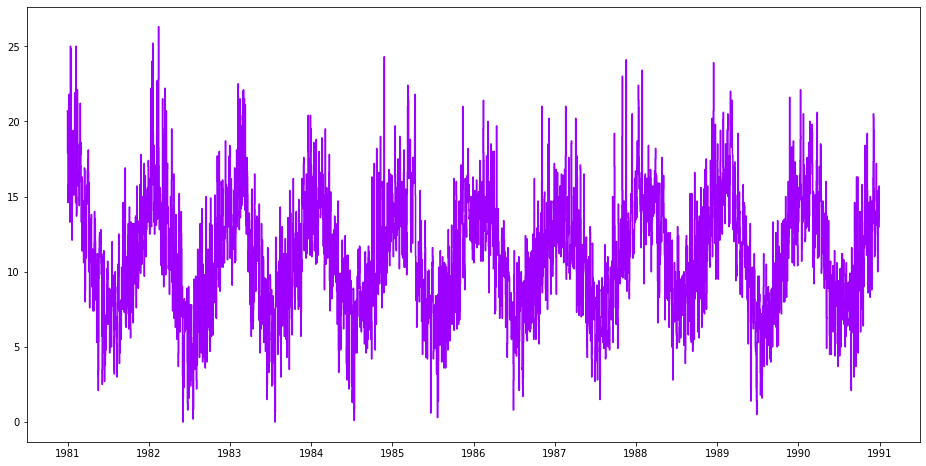

In [4]:
vals = np.diff(df_temps.Temp,prepend=0)
temps_steps = Steps.read_dataframe(df_temps,start='Date',weight='Temp',convert_delta=True)
ax = temps_steps.plot()


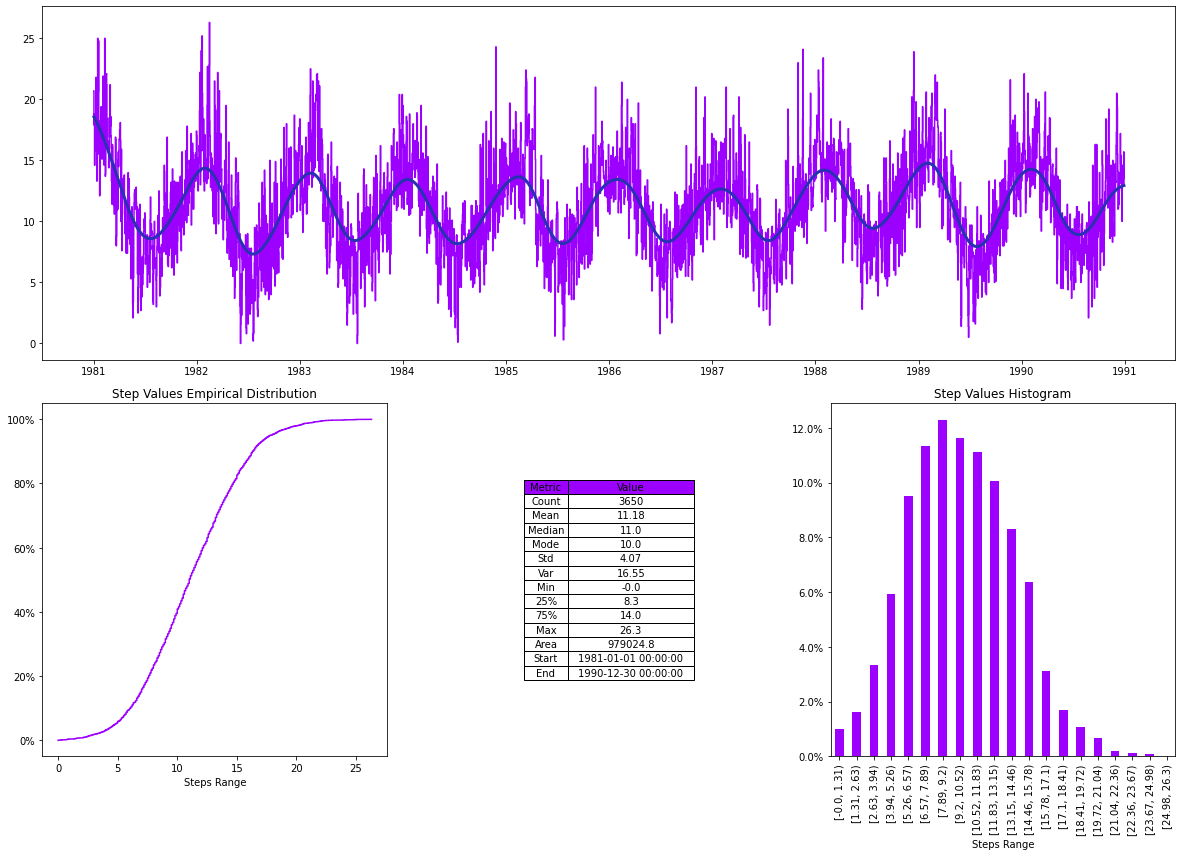

In [5]:
temps_steps.summary();

From the summary view of the data, we can clearly see that there is a cycle in the data, so the next question is, how long is this? Some quick ways to see the nature of time series is to use auto correlation and partial auto correlation. Luckily, out of the box, Hotstepper implements both. We can expect a large correlation between the 1st and 2nd lag,s therefore we can exclude them from the chart to get a better look at the remaining lags.

<AxesSubplot:title={'center':'Steps Partial Autocorrelation for Lags = 50'}, xlabel='Lag'>

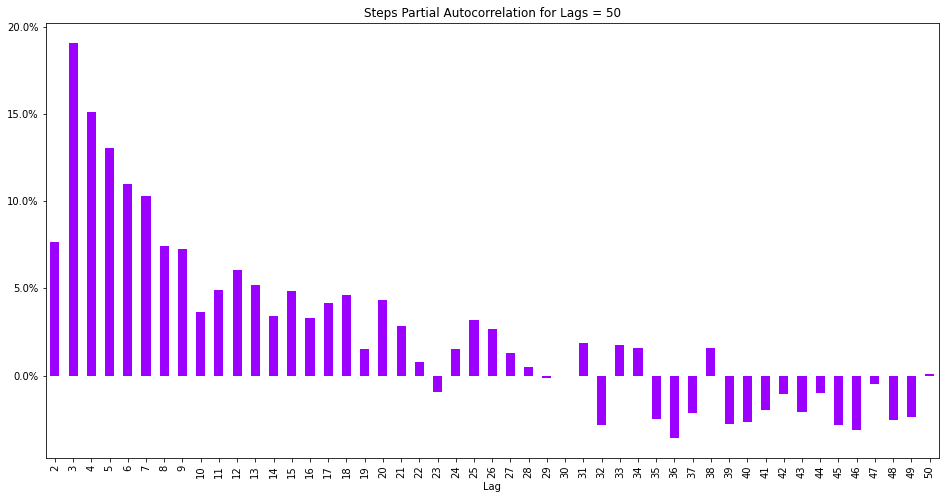

In [6]:
temps_steps.pacf_plot(50,2)


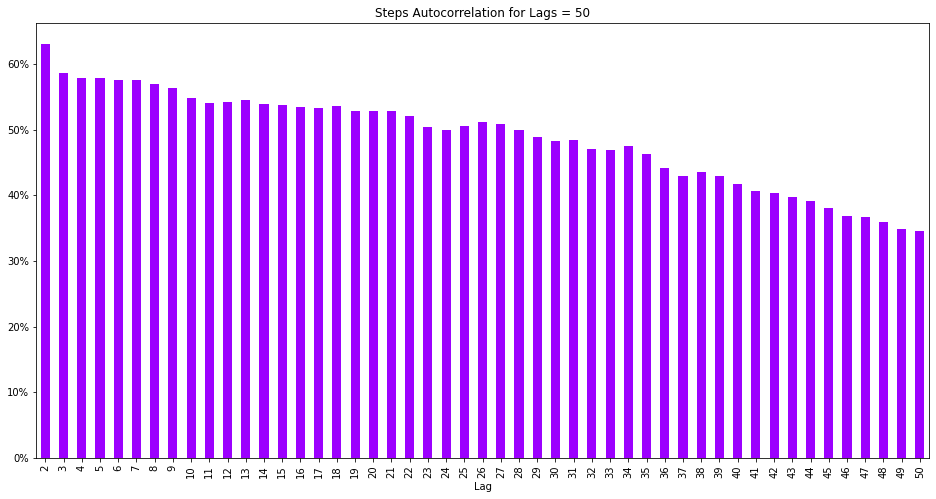

In [7]:
temps_steps.acf_plot(50,2);

So we have 

How often was it over 20 degrees?
This is a good lesson to understand that step functions aren't the same as regular functions.

If we naively filter the data and take the ratio to the total of the days having a temperature greater than 20 degrees, we would have an incorrect result.

In [8]:
temps_step20 = (temps_steps>20)
gt20 = temps_step20.normalise().integrate()/temps_steps.normalise().integrate()

gt20_df = df_temps[df_temps.Temp > 20]['Temp'].count()/df_temps['Temp'].count()

print(f"Percentage days greater than 20 degrees, via steps {gt20}")
print(f"Percentage days greater than 20 degrees, via pandas {gt20_df}")

Percentage days greater than 20 degrees, via steps 0.019999999999999993
Percentage days greater than 20 degrees, via pandas 0.020273972602739727


So what has happened?, the simple answer is that we are are only evaluating the step function on and after each step key, therefore, if the first day is over 20, whilst it is in the steps function, when we include it in the integral, it has no weight, as it exists only at a single instant of the step function.

So, we have to include the full day of the first step, instead of only the value at the edge between the first and second day. The easy way to do this and ensure we don't include anything else is to clamp the values beyond the range of the first full day and the last.

In [9]:
gt20 =(
    temps_step20.clamp(lbound=temps_step20.first()-pd.Timedelta(days=1))
    .normalise()
    .integrate()/temps_steps.normalise().integrate())

print(f"Percentage days greater than 20 degrees, via steps {gt20}")
print(f"Percentage days greater than 20 degrees, via pandas {gt20_df}")

Percentage days greater than 20 degrees, via steps 0.020273972602739724
Percentage days greater than 20 degrees, via pandas 0.020273972602739727


For some reason, we might want to return the steps data as a Pandas Series object, I don't blame you, they are nice and handy, so, through the magic of HotStepper and method chaining, we can create a Series object and call the Pandas.Series.plot method on it.

<AxesSubplot:>

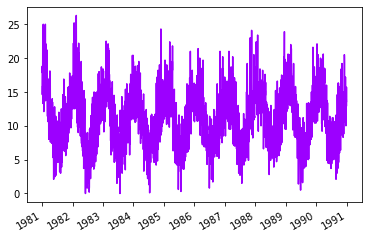

In [11]:

temps_steps.series().plot()
